# Problem 3: How many people live in the dominance area of each shopping center?
Find out how many people live under the dominance area of each shopping center. You should be able to do this based on the output from problem 2, lesson materials from weeks 2, 3 and 4 and these additional hints:

- You can read in the population data from the HSY WFS service: https://kartta.hsy.fi/geoserver/wfs (check more hints from the lesson materials)
- Aggregate your dominance areas from problem 2 into a unified geometries using dissolve() -function in geopandas before joining with the population data.
- Remember to check the crs of the input data.
- Join information between the population grid and the dominance areas -layer using intersect as the condition in the spatial join.

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import pandas as pd
import os 

You can read in the population data from the HSY WFS service: https://kartta.hsy.fi/geoserver/wfs 

- Found in Lesson 3 Spatial Join

In [32]:
import requests
import geojson

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

In [33]:
#display population data
pop.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,"POLYGON ((25472499.995 6689749.005, 25472499.9...",688,9,28.0,99,99,99,99,99,99,99,99,99
1,"POLYGON ((25472499.995 6685998.998, 25472499.9...",703,5,51.0,99,99,99,99,99,99,99,99,99
2,"POLYGON ((25472499.995 6684249.004, 25472499.9...",710,8,44.0,99,99,99,99,99,99,99,99,99
3,"POLYGON ((25472499.995 6683999.005, 25472499.9...",711,5,90.0,99,99,99,99,99,99,99,99,99
4,"POLYGON ((25472499.995 6682998.998, 25472499.9...",715,11,41.0,99,99,99,99,99,99,99,99,99


In [34]:
pop.shape

(5832, 13)

In [35]:
# Change the name of a column
pop = pop.rename(columns={'asukkaita': 'pop18'})

# Check the column names
pop.columns

Index(['geometry', 'index', 'pop18', 'asvaljyys', 'ika0_9', 'ika10_19',
       'ika20_29', 'ika30_39', 'ika40_49', 'ika50_59', 'ika60_69', 'ika70_79',
       'ika_yli80'],
      dtype='object')

Let’s also get rid of all unnecessary columns by selecting only columns that we need i.e. pop18 and geometry

In [36]:
# Subset columns
pop = pop[["pop18", "geometry"]]

pop.head()

,pop18,geometry
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


# Create Grid File

- Extract txt file paths

In [37]:
import re 

directory = r"exercise-4-main/data"
grid_file = r"MetropAccess_YKR_grid_EurefFIN.shp"
grid_path = os.path.join(directory, grid_file)


list_of_files = os.listdir(directory)
list_of_travel_time_files = []

for file in list_of_files:
    if '.txt' in file:
        list_of_travel_time_files.append(os.path.join(directory, file))

print(list_of_travel_time_files, " length of: ", len(list_of_travel_time_files) )

#split string by '_' seperator
#extract 'XXXX.txt'
#extract XXXX, by removing '.txt' portion of the string, subscript -4
shopping_center_example = re.split(r'_', list_of_files[8])[3][:-4]

shopping_center_names_list = []

#repeat for all shopping centers
for shopping_center in list_of_travel_time_files:
    shopping_center_names_list.append( re.split(r'_', shopping_center)[3][:-4] )

print(shopping_center_names_list)

['exercise-4-main/data\\TravelTimes_to_5878070_Jumbo.txt', 'exercise-4-main/data\\TravelTimes_to_5878087_Dixi.txt', 'exercise-4-main/data\\TravelTimes_to_5902043_Myyrmanni.txt', 'exercise-4-main/data\\TravelTimes_to_5944003_Itis.txt', 'exercise-4-main/data\\TravelTimes_to_5975373_Forum.txt', 'exercise-4-main/data\\TravelTimes_to_5978593_IsoOmena.txt', 'exercise-4-main/data\\TravelTimes_to_5980260_Ruoholahti.txt']  length of:  7
['Jumbo', 'Dixi', 'Myyrmanni', 'Itis', 'Forum', 'IsoOmena', 'Ruoholahti']


- Import grid file 
- merge grid geodataframe  with pandas dataframe for each shopping center using ID key match

In [38]:
from pyproj import CRS

#read in grid shapefile
grid = gpd.read_file(grid_path)

#transform the crs of grid shapefile before performing the aggregation of geometry features using 'dissolve' (after dissolving, cant transform crs of multipolygon feature)
grid = grid.to_crs(CRS.from_epsg(3879))

#read each txt file as a data frame store in the list
for file, shopping_center in zip(list_of_travel_time_files, shopping_center_names_list):
    
    data = pd.read_csv(file, sep=';') 
    
    #generate new column name
    title_string = 'pt_r_t_{val}'.format(val = shopping_center)
    
    #create a new column using values from the 'pt_r_t' column
    data[title_string] = data[ [ 'pt_r_t' ] ] 
    
    data.drop(columns=['pt_r_t'], axis=1, inplace=True)
    
    #create a smaller subset of data, join both tables using YKR_ID from grid and from_id of data, overwrite the previous dataframe
    grid = grid.merge(data[ [title_string, 'from_id'] ],  how='outer', left_on = 'YKR_ID', right_on ='from_id')
    
    grid.drop(columns = ['from_id'], axis=1, inplace=True)

- calculate the minimum travel time for each row 
- identify the shopping center with the shortest travel time on each row

In [39]:
columns_for_comparison = grid.columns[4:]

#extract the min value from current row
row_min =  grid[ columns_for_comparison ].idxmin(axis='columns',skipna=True)

#test row_min
print(len(row_min))

dominant_service = []
min_t = []
for index in range(0,len(row_min)):
    min_t.append( grid.at[index, row_min[index]] )
    dominant_service.append( re.split(r'_', row_min[index])[3])
    
grid['min_t'] = min_t
grid['dominant_service'] = dominant_service

13231


- Remove null values from the grid geodataframe

In [40]:
import numpy as np

#more efficient way of removing null values from dataframe
grid.replace(-1, np.nan, inplace=True)

#drop NA values if there any NA values in thw row, do not make a copy of the instance.
grid.dropna(axis=0, how='any', inplace=True)

grid.reset_index( inplace=True)

print("simplified NA removal: " , len(grid))

simplified NA removal:  13020


- aggregate geometry by shopping center label

In [41]:
#check column labels
grid.columns

Index(['index', 'x', 'y', 'YKR_ID', 'geometry', 'pt_r_t_Jumbo', 'pt_r_t_Dixi',
       'pt_r_t_Myyrmanni', 'pt_r_t_Itis', 'pt_r_t_Forum', 'pt_r_t_IsoOmena',
       'pt_r_t_Ruoholahti', 'min_t', 'dominant_service'],
      dtype='object')

- Aggregate your dominance areas from problem 2 into a unified geometries using dissolve() -function in geopandas before joining with the population data.

In [42]:
# how the dissolve function works:
#https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html

data_geo = grid.dissolve(by= 'dominant_service')

data_geo.head()

,geometry,index,x,y,YKR_ID,pt_r_t_Jumbo,pt_r_t_Dixi,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Forum,pt_r_t_IsoOmena,pt_r_t_Ruoholahti,min_t
dominant_service,,,,,,,,,,,,,
Dixi,"MULTIPOLYGON (((25495260.623 6688105.784, 2549...",211,392625.0,6694630.0,5810457,66.0,54.0,85.0,79.0,77.0,106.0,82.0,54.0
Forum,"MULTIPOLYGON (((25472713.235 6689172.913, 2547...",512,376875.0,6693130.0,5821788,109.0,125.0,106.0,124.0,105.0,131.0,119.0,105.0
IsoOmena,"MULTIPOLYGON (((25472183.044 6690157.462, 2547...",1635,361875.0,6690130.0,5844368,107.0,93.0,73.0,106.0,80.0,72.0,82.0,72.0
Itis,"MULTIPOLYGON (((25494972.968 6681092.184, 2549...",4190,402125.0,6685880.0,5876274,98.0,85.0,97.0,55.0,79.0,100.0,80.0,55.0
Jumbo,"MULTIPOLYGON (((25485293.308 6686802.751, 2548...",210,384125.0,6694630.0,5810423,104.0,105.0,107.0,142.0,126.0,159.0,134.0,104.0


In [43]:
#extract the aggregated grids and dominant service center
data_geo = data_geo[ ['geometry'] ] 

data_geo.head()

,geometry
dominant_service,
Dixi,"MULTIPOLYGON (((25495260.623 6688105.784, 2549..."
Forum,"MULTIPOLYGON (((25472713.235 6689172.913, 2547..."
IsoOmena,"MULTIPOLYGON (((25472183.044 6690157.462, 2547..."
Itis,"MULTIPOLYGON (((25494972.968 6681092.184, 2549..."
Jumbo,"MULTIPOLYGON (((25485293.308 6686802.751, 2548..."


- Remember to check the crs of the input data.

In [44]:
#check crs of grid
print(data_geo.crs)

epsg:3879


In [45]:
#check crs of population grid
print(pop.crs)

None


In [46]:
pop.crs = CRS.from_epsg(3879)
assert data_geo.crs == pop.crs, "CRS of population and Grids are not equal"

- Join information between the population grid and the dominance areas -layer using intersect as the condition in the spatial join.

In [47]:
#reference for sjoin: https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html

#inner join to preserve column attributes from both geodataframes, preserve the geometry of population grid
nearest_shopping_center= gpd.sjoin(pop, data_geo, how='inner', predicate='intersects')

nearest_shopping_center.rename( columns= { 'index_right': 'nearest_shopping_center' } ,inplace=True)

nearest_shopping_center.head()

,pop18,geometry,nearest_shopping_center
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9...",IsoOmena
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9...",IsoOmena
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9...",IsoOmena
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9...",IsoOmena
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9...",IsoOmena


- check if the projection of grids & population match.

<AxesSubplot:>

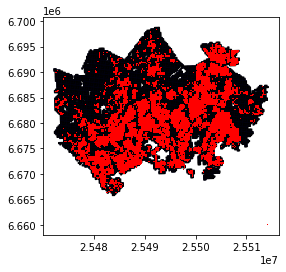

In [48]:
#https://geopandas.org/en/stable/docs/user_guide/mapping.html

#method 1 example of docs
base = grid.plot(color='blue', edgecolor='black')
pop.plot(ax=base, marker='o', color='red', markersize=5)

- Result

The total population near each shopping center district in 2018

In [49]:
nearest_shopping_center.groupby(by=['nearest_shopping_center']).sum()

,pop18
nearest_shopping_center,
Dixi,223770
Forum,259697
IsoOmena,201205
Itis,212502
Jumbo,79573
Myyrmanni,231630
Ruoholahti,87856


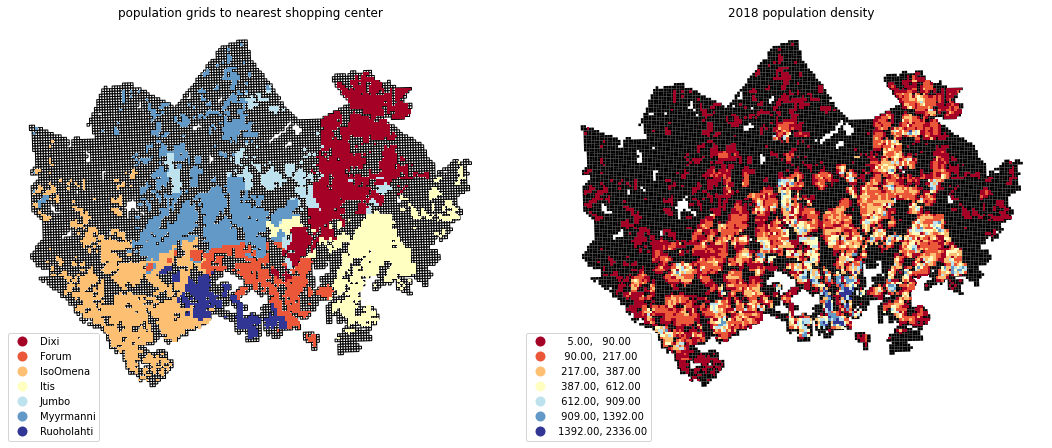

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

base = grid.plot(ax=axs[0], color='white', edgecolor='black')
plot1 = nearest_shopping_center.plot(ax=base, column='nearest_shopping_center', legend=True, cmap="RdYlBu", k=7)
plot1.set_title('population grids to nearest shopping center')
plot1.axis('off')
leg1 = plot1.get_legend()
leg1.set_bbox_to_anchor((0., 0., 0.2, 0.2))

newbase = grid.plot(ax=axs[1], color='black')
plot2 = nearest_shopping_center.plot(ax=newbase, column= "pop18", scheme= "Natural_Breaks", k=7, cmap="RdYlBu", linewidth=0, legend =True,figsize=(10,5))
plot2.set_title('2018 population density')
plot2.axis('off')
leg2 = plot2.get_legend()
leg2.set_bbox_to_anchor((0., 0., 0.2, 0.2))

plt.tight_layout()

plt.show()